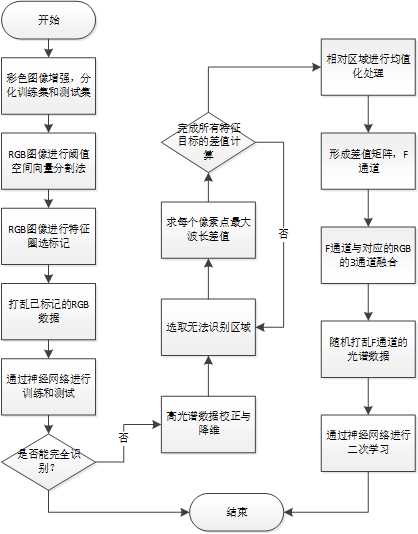# 文章思路

基于深度学习的RGB与高光谱的烟草识别方法，其特征在于：具体包括以下步骤：
- 步骤1，获取烟丝的彩色图像和高光谱图像；
- 步骤2：对彩色图像增强处理，扩大图像数据的数据量得到图像样本库，并对其随机分成训练集和测试集；
- 步骤3：将对应RGB图像进行分割，运用对数系数阈值空间向量分割法，对应RGB图像的3个通道，对每个像素点采取一个相似度量；
- 步骤4：采用圈选对RGB图像中的特征进行标记，通过RGB图像的标记对应产生F通道的标记；
- 步骤5：添加特征标签后，将RGB图像数据随机性的打乱并将分类标签转化为独热编码，生成便于神经网络进行训练和测试的标签数据；
- 步骤6：对获得的高光谱数据进行校正与降噪；
- 步骤7，利用高光谱差值矩阵法，构建光谱特征F通道，对RGB中的相近色块使用深度学习结合F通道数据进行二次识别。

![main_graph](./assets/0.png)

Main Contribution:
1. 构建出一种光谱图像可视化增强方案

1. 构建光谱特征F通道
2. 差异大的色块快速滤除
3. 近色块使用深度学习结合F通道数据进行二次识别


In [29]:
# import Python packages
import mitosheet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from scipy import interpolate
%matplotlib inline

# import torch

## 数据读入与预处理

首先将数据读进来，进行色彩图像的生成，获得可分割且符合直觉的色彩图像

In [30]:
raw_file_name, raw_file_shape = "/home/share/dataset/calibrated34.raw", (600, 1024, 448)
with open(raw_file_name, "rb") as f:
    raw_spectra = np.frombuffer(f.read(), dtype=np.float32).reshape((600, 448, 1024)).transpose(0, 2, 1)
print(raw_spectra.shape)
print(f"The value of the raw spectra are all more than 0" if np.all(raw_spectra>=0)
      else f"Some value in the raw spectra is less than 0, we will set them to 0.")
print(f"The value of the raw spectra are all less than 1" if np.all(raw_spectra<=1)
      else f"Some value in the raw spectra is higher than 1, we will set them to 1.")
# raw_spectra = (raw_spectra - raw_spectra.min()) / raw_spectra.max()
# raw_spectra = np.clip(raw_spectra, a_min=0, a_max=1)
print(f"The value of the raw spectra are all more than 0" if np.all(raw_spectra>=0)
      else f"Some value in the raw spectra is less than 0, we will set them to 0.")
print(f"The value of the raw spectra are all less than 1" if np.all(raw_spectra<=1)
      else f"Some value in the raw spectra is higher than 1, we will set them to 1.")

(600, 1024, 448)
Some value in the raw spectra is less than 0, we will set them to 0.
Some value in the raw spectra is higher than 1, we will set them to 1.
Some value in the raw spectra is less than 0, we will set them to 0.
Some value in the raw spectra is higher than 1, we will set them to 1.


[[0.05503066 0.06281172 0.05715815 ... 0.0617195  0.05991093 0.05985855]
 [0.05222024 0.05441015 0.05528323 ... 0.0573748  0.05816934 0.06072714]
 [0.04940982 0.04694209 0.0515334  ... 0.06085056 0.06426492 0.06246433]
 ...
 [0.05409385 0.05160963 0.05715815 ... 0.06345738 0.06078173 0.06159573]
 [0.05315704 0.06187821 0.05434578 ... 0.06606419 0.06687732 0.06333292]
 [0.05596746 0.05814418 0.05434578 ... 0.05824374 0.06252333 0.06072714]]


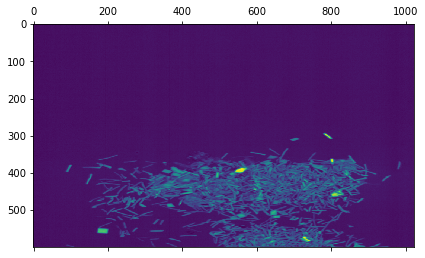

In [31]:
print(raw_spectra[:, :, 200])
plt.matshow(raw_spectra[:, :, 200])
plt.show()

## 人眼视角模拟与增强
为了能够更好的模拟人眼的视角，使用一种基于正态分布的加权式色彩增强方案，得到的结果如下：
目的是在CIE1964的标准上进行改进，然后将色彩进行合理的变换。
找出差异最大的区域进行色彩的增强。
![1.png](./assets/1.png)
r_wavelength =700   g_wavelength = 520 b_wavelength=420


在视野范围内的波长进行拉伸放缩，对现有的波段数据进行扩充来达到放缩的过程；
对相邻的波段的图像进行取平均生成新的图像插入之间，从而达到拉伸的效果，进行平滑处理。

### 标准光谱色彩转换(CIE1964)

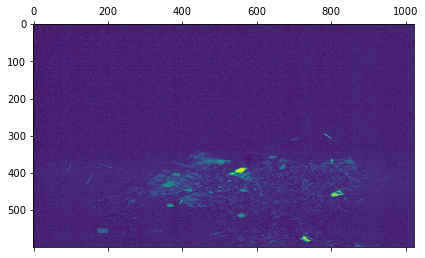

In [83]:
cie_file = "../share/dataset/CIE1964d10.csv"
data_hdr = "../share/dataset/wavelength.csv"


cie1964d10 = pd.read_csv(cie_file, header=0, index_col=0)
cie1964d10 = cie1964d10.loc[400: 680]
weights = cie1964d10.values
data_wavelength = pd.read_csv(data_hdr, header=None, index_col=None).values
data_collected_for_cie = []
for wavelength in cie1964d10.index:
    error_vect = np.abs(data_wavelength - wavelength)
    required_idx = np.argmin(error_vect)
    error = np.min(error_vect)
    if error > 1:
        print(f"{wavelength}nm get suitable spectra channel failed,"
              "the error is {error}")
    data_collected_for_cie.append(raw_spectra[:, :, required_idx][..., np.newaxis])
data_collected_for_cie = np.concatenate(data_collected_for_cie, axis=2)
plt.matshow(data_collected_for_cie[..., 80])
plt.show()
h, w = data_collected_for_cie.shape[0], data_collected_for_cie.shape[1]
xyz_img = np.dot(data_collected_for_cie, weights)

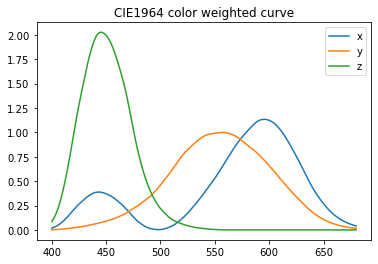

In [86]:
fig, axs = plt.subplots()
axs.plot(cie1964d10.index, weights[:, 0], label='x')
axs.plot(cie1964d10.index, weights[:, 1], label='y')
axs.plot(cie1964d10.index, weights[:, 2], label='z')
plt.title("CIE1964 color weighted curve")
plt.legend()
plt.show()

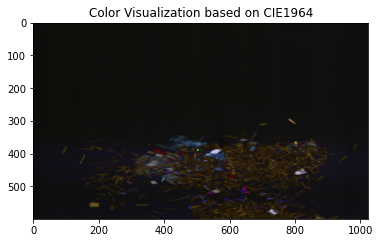

In [87]:
matrix_m_invers = np.array([[3.2406, -1.5372, -0.4986], [-0.9689, 1.8758, 0.0415], [0.0557, -0.2040, 1.0570]])
matrix_m = np.array([[2.7688, 1.7517, 1.1301], [1, 4.5906, 0.0601], [0, 0.0565, 5.5942]])
rgb_img = np.dot(xyz_img, matrix_m_invers)
rgb_img[:, :, 0] *= 0.293
rgb_img = rgb_img/rgb_img.max()
rgb_img = np.array(rgb_img * 255, dtype=np.uint8)
cv2.imwrite("output.bmp", rgb_img[..., ::-1])
plt.imshow(rgb_img)
plt.title("Color Visualization based on CIE1964")
plt.show()

基于CIE1964，我们设计了一个工具函数，可以将光谱图像转化为彩色图像

### 色彩曲线的拉伸
idea来自于ref

首先对CIE1964的曲线进行平移拉伸

In [35]:
def transfered_weight(dst_wavelength_start, dst_wavelength_end):
    data_wavelength = cie1964d10.loc[400:680].index
    normalized_point = (data_wavelength - data_wavelength[0])/(data_wavelength[-1]-data_wavelength[0])
    new_datawavelength = normalized_point * (dst_wavelength_end - dst_wavelength_start) + dst_wavelength_start
    return new_datawavelength

In [75]:
print(data_wavelength[0], data_wavelength[-1])
new_datawavelength = transfered_weight(data_wavelength[0], data_wavelength[-1])

[400.] [998.661]


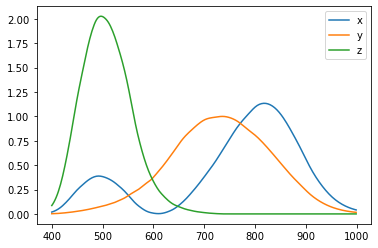

In [76]:
fig, axs = plt.subplots()
axs.plot(new_datawavelength, weights[:, 0], label='x')
axs.plot(new_datawavelength, weights[:, 1], label='y')
axs.plot(new_datawavelength, weights[:, 2], label='z')
plt.legend()
plt.show()

插值

In [80]:
m = new_datawavelength
x = weights[:, 0]
y = weights[:, 1]
z = weights[:, 2]
f = interpolate.interp1d(m, x, kind='cubic')
g = interpolate.interp1d(m, y, kind='cubic')
h = interpolate.interp1d(m, z, kind='cubic')
# f = interpolate.lagrange(m, x)
# g = interpolate.lagrange(m, y)
# h = interpolate.lagrange(m, z)
Mnew = data_wavelength
x_stretch = f(Mnew) # use interpolation function returned by `interp1d`
y_stretch = g(Mnew)
z_stretch = h(Mnew)
print(x_stretch.shape, y_stretch.shape, z_stretch.shape)

(448, 1) (448, 1) (448, 1)


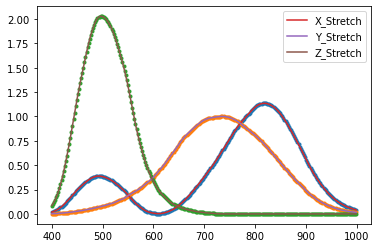

In [81]:
fig, axs = plt.subplots()
plt.plot(m, x, '.')
plt.plot(m, y, '.')
plt.plot(m, z, '.')
axs.plot(Mnew, x_stretch, label='X_Stretch')
axs.plot(Mnew, y_stretch, label='Y_Stretch')
axs.plot(Mnew, z_stretch, label='Z_Stretch')
plt.legend()
plt.show()

In [82]:
stretched_weights = np.concatenate([x_stretch, y_stretch, z_stretch], axis=1)

在这里将进行的是基于CIE 1964标准变化

(600, 1024)


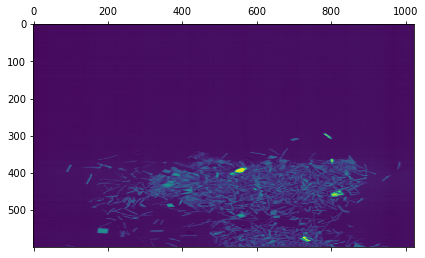

In [7]:
df = pd.read_excel(r"./assets/dataRGB.xlsx", sheet_name="Sheet1", usecols=[0])
df_li = df.values.tolist()
result = []
for s_li in df_li:
    result.append(s_li[0])
# print(len(result))
ggg = np.array(result, dtype=np.float32)
X = 0
X_x = []
for i in range(322):
    X += raw_spectra[:, :, i] * ggg[i]
print(X.shape)
plt.matshow(X/322)
plt.show()

[[4.3406587 4.3982654 4.601532  ... 5.456284  5.3071685 5.343765 ]
 [4.659819  4.6144037 4.851241  ... 5.6096034 5.460519  5.407349 ]
 [4.53443   4.58638   4.724986  ... 5.5199857 5.246796  5.316947 ]
 ...
 [4.5533237 4.5982676 4.6572046 ... 5.5162997 5.3626666 5.541562 ]
 [4.6941214 4.667219  4.7887955 ... 5.510847  5.6136913 5.3977065]
 [4.8353453 5.0414557 5.0759726 ... 5.7864013 5.7913876 5.723219 ]]


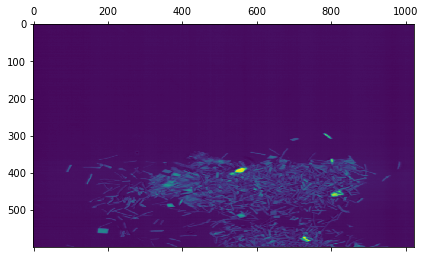

In [8]:
df = pd.read_excel(r"./assets/dataRGB.xlsx", sheet_name="Sheet1", usecols=[1])
df_li = df.values.tolist()
result = []
for s_li in df_li:
    result.append(s_li[0])
# print(len(result))
Y = 0
for i in range(322):
    
    Y += raw_spectra[:, :, i] * result[i]
print(Y)
plt.matshow(Y/322)
plt.show()

[[3.4612134 4.085523  4.4257355 ... 5.870752  5.4849377 6.039073 ]
 [5.112929  5.5231967 6.0872645 ... 7.287183  6.4402905 6.552446 ]
 [4.243287  4.8094754 5.481134  ... 6.1235986 5.966574  6.254479 ]
 ...
 [5.090605  4.7498794 5.244874  ... 7.1041627 6.83426   7.756946 ]
 [5.0900135 5.1474733 5.894396  ... 8.313045  8.039494  7.25198  ]
 [5.701587  7.0565057 7.0261335 ... 7.962558  8.712479  8.239078 ]]


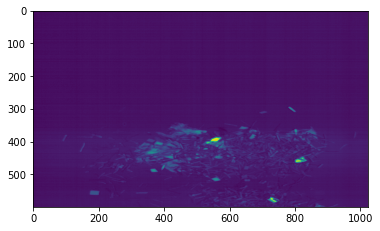

In [22]:
df = pd.read_excel(r"./assets/dataRGB.xls", sheet_name="Sheet1", usecols=[2])
df_li = df.values.tolist()
result = []
for s_li in df_li:
    result.append(s_li[0])
# print(len(result))
Z = 0
for i in range(322):
    Z += raw_spectra[:, :, i] * result[i]
print(Z)
plt.matshow(Z/322)
plt.show()

融合的RGB颜色尝试


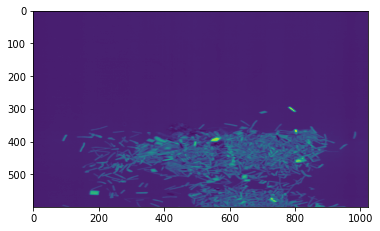

In [21]:
R = (X/32200)*3.2406+(Y/32200)*-1.5372+(Z/32200)*-0.4986
G = (X/32200)*-0.9689+(Y/32200)*1.8758+(Z/32200)*0.0415
B = (X/32200)*0.0557+(Y/32200)*-0.2040+(Z/32200)*1.0570
plt.matshow(R)
plt.show()

In [11]:

sum1 = 0
X_ stretch = raw_spectra
torch_raw_spectra = torch.tensor(raw_spectra)


torch_sum1 = (torch_raw_spectra[:, :, :-1] + torch_raw_spectra[:, :, 1:]) / 2
torch_sum1 = torch.concat([
    torch_sum1.repeat_interleave(2, dim=2),
    torch.zeros((list(torch_sum1.shape[:2]) + [1, ]), dtype=torch.float)
], dim=2)
torch_sum1[:, :, 0::2] = 0.0
torch_raw_spectra = torch_raw_spectra.repeat_interleave(2, dim=2)
torch_raw_spectra[:, :, 1::2] = 0.0
b = torch_sum1+torch_raw_spectra[:, :, :-1]
print(b.shape)

# torch.masked_scatter
# for i in range(0, 446):
#     sum1 = (raw_spectra[:, :, i] + raw_spectra[:, :, i+1])/2
#     np.insert(y[:, :, i+1], sum1)
# print(y)
# print(y.shape)


torch.Size([600, 1024, 895])


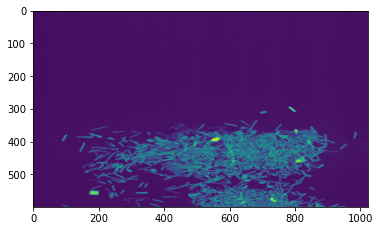

In [20]:
plt.matshow(b[:, :, 500])
plt.show()

In [13]:
# # create some simple data to display
# b_0 = pd.DataFrame(b[:, :, 0])
# b_1 = pd.DataFrame(b[:, :, 1])
# b_2 = pd.DataFrame(b[:, :, 2])

# # render the Mitosheet with the data
# mitosheet.sheet(b_0, b_1, b_2, ((b_0+b_2)/2))

## 构建特征F通道



为了分类快速，可以构建一个特殊的通道，在该通道内确保各类的差异最大。

In [14]:
def generate_dataset(spectral_data: np.ndarray, label_data: np.ndarray):
    dataset_dict = {}
    h, w = label_data.shape[0], label_data.shape[1]
    assert (w == spectral_data.shape[1]) and (h == spectral_data.shape[0])
    for x, y in [(x, y) for x in range(h) for y in range(w)]:
        r, g, b = label_data[x, y]
        if (r, g, b) in dataset_dict:
            dataset_dict[(r, g, b)].append(((x, y), spectral_data[x, y, ...]))
        else:
            dataset_dict[(r, g, b)] = [((x, y), spectral_data[x, y, ...])]
    return dataset_dict

In [15]:
label_file = "/home/share/dataset/calibrated34.png"
label_data = cv2.imread(label_file)[::-1]
print(label_data.shape)
print(raw_spectra.shape)
dataset = generate_dataset(raw_spectra, label_data)
_ = [print(x, len(dataset[x]), dataset[x][-1][-1].shape, dataset[x][-1][0]) for x in dataset]

(600, 1024, 3)
(600, 1024, 448)
(255, 255, 255) 590454 (448,) (599, 1023)
(0, 0, 255) 23945 (448,) (306, 788)
(254, 254, 255) 1 (448,) (165, 507)


## 构建分类模型和流程


## 结论